In [17]:
# Set to false if working on local env
onColab = False

model_path = './multimodel_2'

# Decide batch size and validation split
batch_size = 128
validation_split = 0.2
epochs = 200

dataset_path = './Training.csv'

In [18]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

In [19]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

tf.config.list_physical_devices('GPU')

2.7.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [21]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
# dataset.head()

(68528, 7)


In [22]:
# dataset.info()

In [23]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
# inspect_dataframe(dataset, dataset.columns)

In [24]:
def preproc(data):
  min = data.min()
  max = data.max()
  return (data - min) / (max - min), min, max

In [25]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df.copy().values
    padding_len = len(df) % window

    if(padding_len != 0):
        # Compute padding length
        temp_df = temp_df[padding_len:]
        # padding_len = window - len(df)%window
        # if len(df.shape) > 1:
        #   padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        # else:
        #   padding  = np.zeros((padding_len), dtype='float64')
        # temp_df = np.concatenate((padding,df))
        # if len(df.shape) > 1:
        #   padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        # else:
        #   padding  = np.zeros((padding_len), dtype='float64')
        # temp_label = np.concatenate((padding,temp_label))
        # assert len(temp_df) % window == 0

    print(temp_df.shape)
    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
      if len(df.shape) > 1:
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])
      else:
        dataset.append([[i] for i in temp_df[idx:idx+window]])
        labels.append([[i] for i in temp_label[idx+window:idx+window+telescope]])

    dataset = np.array(dataset)
    print(dataset.shape)
    labels = np.array(labels)

    return dataset, labels

In [26]:
data = {}
data['path'] = []
data['window'] = []
data['stride'] = []
data['telescope'] = []
data['data'] = []
data['data_seg'] = []

# sponginess
data['path'].append(model_path + '/sponginess')
data['window'].append(600)
data['stride'].append(10)
data['telescope'].append(108)
data['data'].append(preproc(dataset['Sponginess']))
data['data_seg'].append(build_sequences(data['data'][-1][0], [data['data'][-1][0].name], data['window'][-1], data['stride'][-1], data['telescope'][-1]))

# wonder level + loudness on impact
data['path'].append(model_path + '/wonder_loudness')
data['window'].append(600)
data['stride'].append(10)
data['telescope'].append(108)
data['data'].append(preproc(dataset[['Wonder level', 'Loudness on impact']]))
data['data_seg'].append(build_sequences(data['data'][-1][0], data['data'][-1][0].columns, data['window'][-1], data['stride'][-1], data['telescope'][-1]))

# crunchiness + hype root
data['path'].append(model_path + '/crunch_hype')
data['window'].append(600)
data['stride'].append(10)
data['telescope'].append(108)
data['data'].append(preproc(dataset[['Crunchiness', 'Hype root']]))
data['data_seg'].append(build_sequences(data['data'][-1][0], data['data'][-1][0].columns, data['window'][-1], data['stride'][-1], data['telescope'][-1]))

# meme creativity
data['path'].append(model_path + '/meme_creat')
data['window'].append(600)
data['stride'].append(10)
data['telescope'].append(108)
data['data'].append(preproc(dataset['Meme creativity']))
data['data_seg'].append(build_sequences(data['data'][-1][0], [data['data'][-1][0].name], data['window'][-1], data['stride'][-1], data['telescope'][-1]))

# soap slipperiness
data['path'].append(model_path + '/soap_slip')
data['window'].append(600)
data['stride'].append(10)
data['telescope'].append(108)
data['data'].append(preproc(dataset['Soap slipperiness']))
data['data_seg'].append(build_sequences(data['data'][-1][0], [data['data'][-1][0].name], data['window'][-1], data['stride'][-1], data['telescope'][-1]))

(68400,)
(6770, 600, 1)
(68400, 2)
(6770, 600, 2)
(68400, 2)
(6770, 600, 2)
(68400,)
(6770, 600, 1)
(68400,)
(6770, 600, 1)


In [27]:
# print(data)

In [28]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

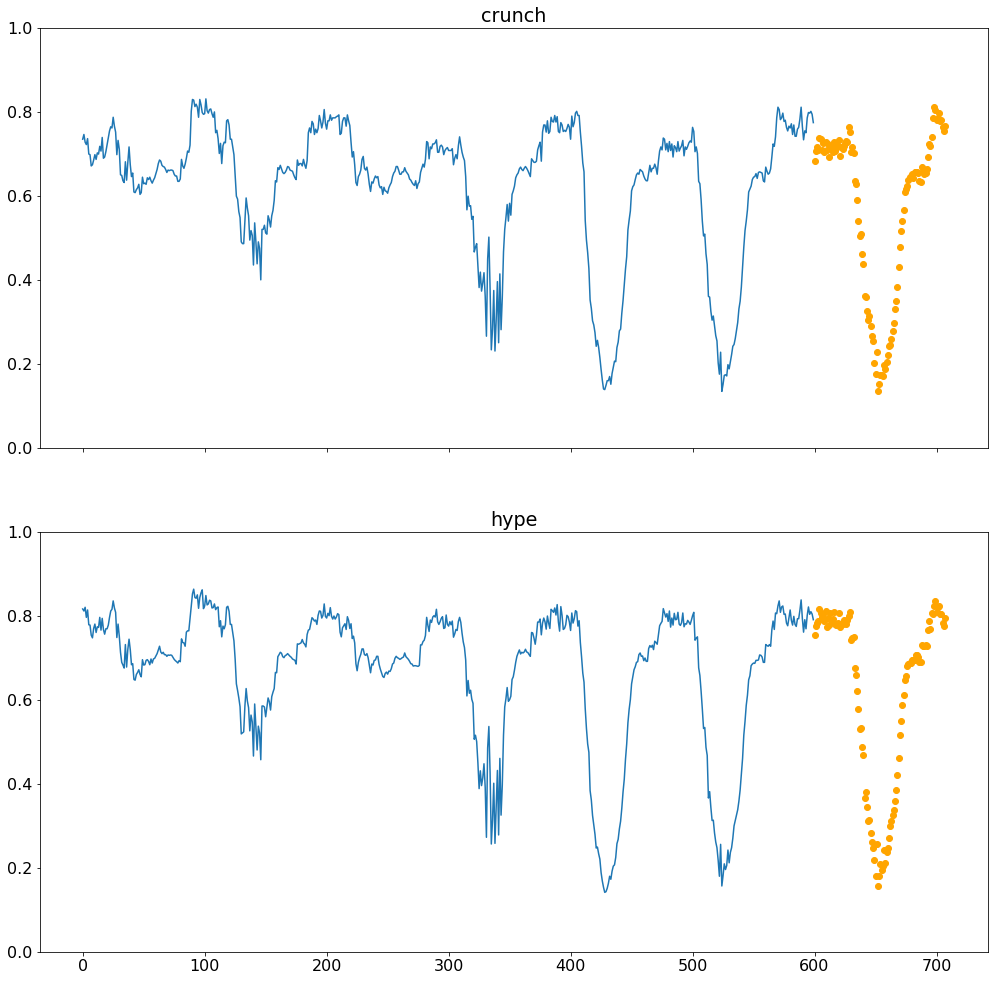

In [29]:
inspect_multivariate(data['data_seg'][-3][0], data['data_seg'][-3][1], ['crunch', 'hype'], data['telescope'][-3])

In [30]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]
    # E2D2
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    #
    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
    #
    model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
    model_e2d2.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e2d2

In [31]:
# input and output shape
data['data_seg'][0][0].shape[1:], data['data_seg'][0][1].shape[1:]

((600, 1), (108, 1))

In [32]:
models = []
for i in range(len(data['path'])):
  print('########################## ' + data['path'][i] + ' ##############################')
  model = build_model(data['data_seg'][i][0].shape[1:], data['data_seg'][i][1].shape[1:])
  model.summary()
  history = model.fit(
      x = data['data_seg'][i][0],
      y = data['data_seg'][i][1],
      batch_size = batch_size,
      epochs = epochs,
      validation_split = validation_split,
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
          # tfk.callbacks.ModelCheckpoint(data['path'][i] + '_ckpt', save_best_only=True)
      ]
  ).history
  model.save(data['path'][i])


########################## ./multimodel_2/sponginess ##############################
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 600, 1)]     0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 600, 100),   40800       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_5 (LSTM)                  [(None, 100),        80400       ['lstm_4[0][0]']                 
        

########################## ./multimodel_2/wonder_loudness ##############################
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 600, 2)]     0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 600, 100),   41200       ['input_3[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_9 (LSTM)                  [(None, 100),        80400       ['lstm_8[0][0]']                 
   

########################## ./multimodel_2/crunch_hype ##############################
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 600, 2)]     0           []                               
                                                                                                  
 lstm_12 (LSTM)                 [(None, 600, 100),   41200       ['input_4[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_13 (LSTM)                 [(None, 100),        80400       ['lstm_12[0][0]']                
       

########################## ./multimodel_2/meme_creat ##############################
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 600, 1)]     0           []                               
                                                                                                  
 lstm_16 (LSTM)                 [(None, 600, 100),   40800       ['input_5[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_17 (LSTM)                 [(None, 100),        80400       ['lstm_16[0][0]']                
        

########################## ./multimodel_2/soap_slip ##############################
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 600, 1)]     0           []                               
                                                                                                  
 lstm_20 (LSTM)                 [(None, 600, 100),   40800       ['input_6[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_21 (LSTM)                 [(None, 100),        80400       ['lstm_20[0][0]']                
         

In [33]:
# best_epoch = np.argmin(history['val_loss'])
# print(best_epoch)
# plt.figure(figsize=(17,4))
# plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
# plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.title('Mean Squared Error (Loss)')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

# plt.figure(figsize=(17,4))
# plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
# plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.title('Mean Absolute Error')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

# plt.figure(figsize=(18,3))
# plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

In [34]:
models = []
for i in data['path']: models.append(tfk.models.load_model(i))

In [35]:
# We did not keep a test set, so we try a couple of measurement on the training (not great strategy, but we had the validation to keep us a bit "safe")
def predict(i):
  predictions = models[i].predict(data['data_seg'][i][0])
  print(predictions.shape)

  mean_squared_error = tfk.metrics.mse(data['data_seg'][i][1].flatten(),predictions.flatten())
  mean_absolute_error = tfk.metrics.mae(data['data_seg'][i][1].flatten(),predictions.flatten())
  print((mean_squared_error, mean_absolute_error))
  return predictions

predictions = []
for i in range(len(models)):
  predictions.append(predict(i))

(6770, 108, 1)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.0016319288>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027578626>)
(6770, 108, 2)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.0032933562>, <tf.Tensor: shape=(), dtype=float32, numpy=0.043723214>)
(6770, 108, 2)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.0016611093>, <tf.Tensor: shape=(), dtype=float32, numpy=0.029468179>)
(6770, 108, 1)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.0026449503>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0386797>)
(6770, 108, 1)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.00066186796>, <tf.Tensor: shape=(), dtype=float32, numpy=0.01907845>)


In [36]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
    print(columns.shape)

    if len(columns) == 1:
      figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,3))
      axs.plot(np.arange(len(X[0,:,0])), X[idx,:,0])
      axs.plot(np.arange(len(X[0,:,0]), len(X[0,:,0])+telescope), y[idx,:,0], color='orange')
      axs.plot(np.arange(len(X[0,:,0]), len(X[0,:,0])+telescope), pred[idx,:,0], color='green')
      axs.set_title(columns[0])
      axs.set_ylim(0,1)
    else:
      figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,6))
      for i, col in enumerate(columns):
          axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
          axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
          axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
          axs[i].set_title(col)
          axs[i].set_ylim(0,1)
    plt.show()

(1,)


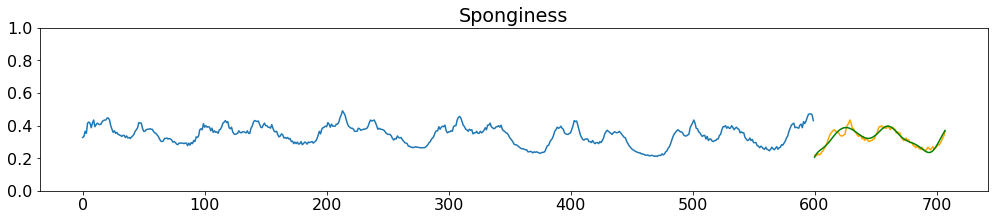

(2,)


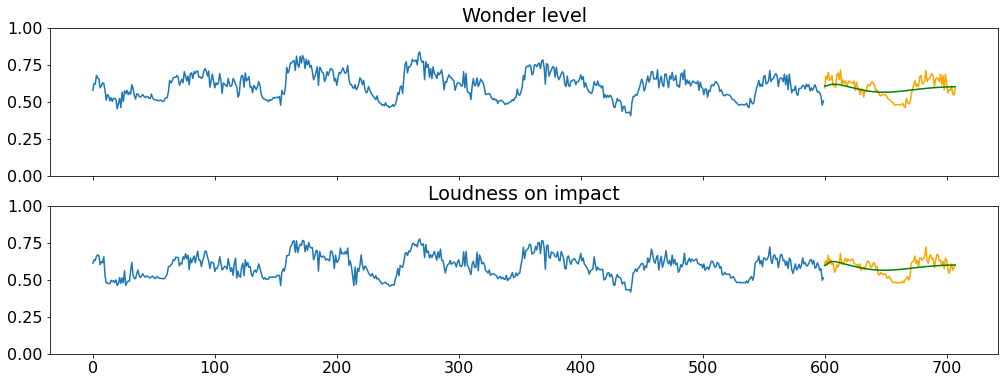

(2,)


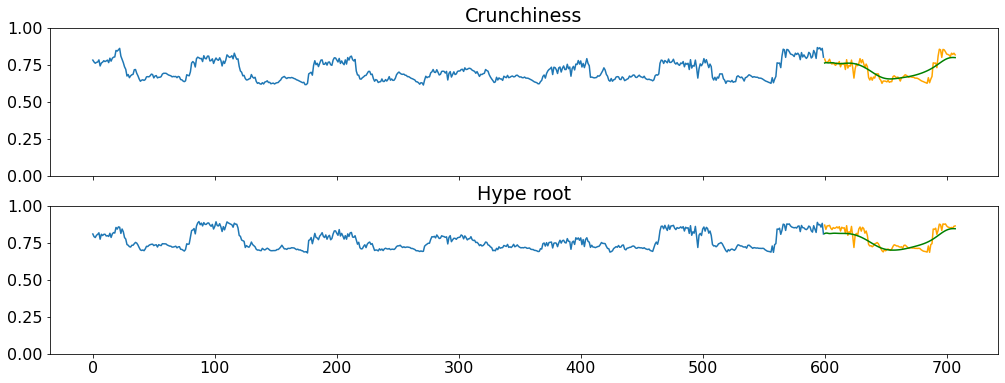

(1,)


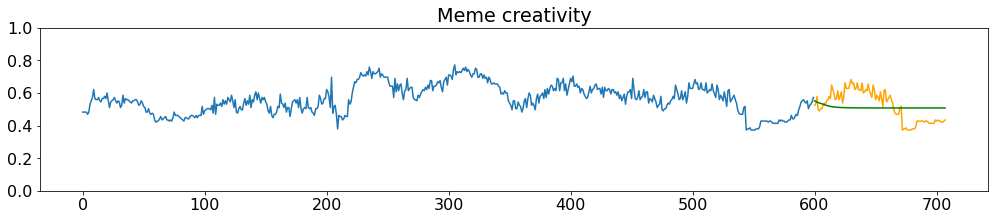

(1,)


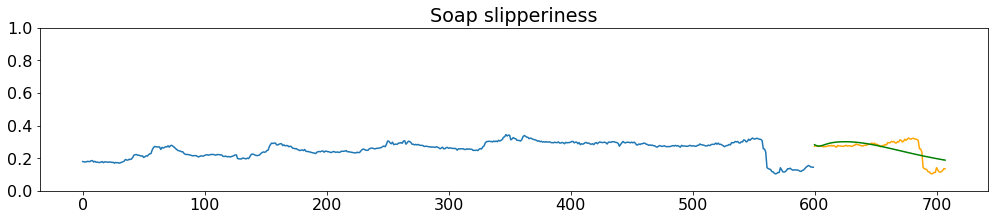

In [37]:
for i in range(len(models)):
  try:
    data['data'][i][0].name
    inspect_multivariate_prediction(data['data_seg'][i][0], data['data_seg'][i][1], predictions[i], np.array([data['data'][i][0].name]), data['telescope'][i])
  except AttributeError:
    inspect_multivariate_prediction(data['data_seg'][i][0], data['data_seg'][i][1], predictions[i], data['data'][i][0].columns, data['telescope'][i])

(68400,)
(112, 600, 1)
(1,)


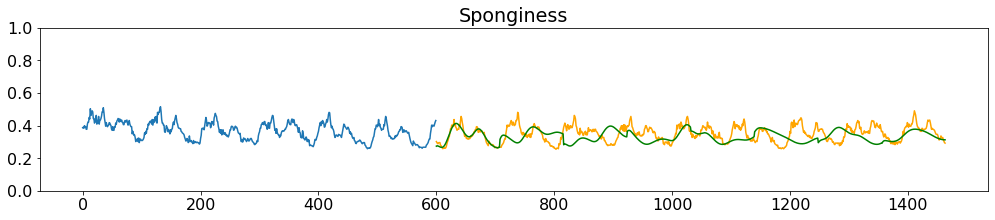

(68400, 2)
(112, 600, 2)
(2,)


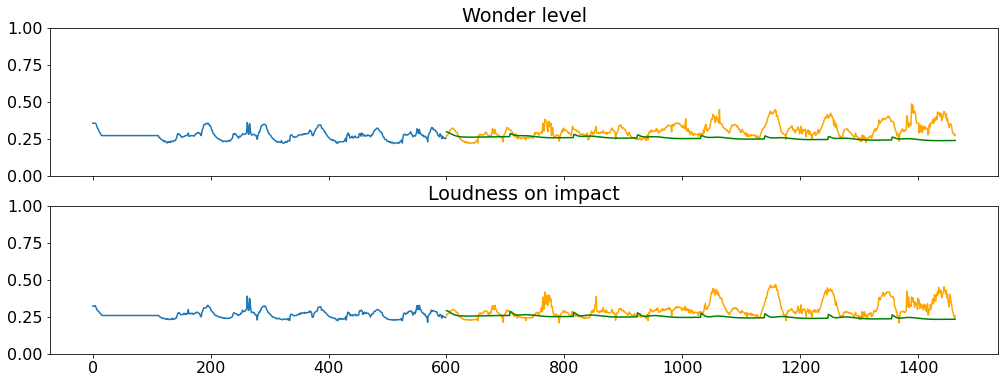

(68400, 2)
(112, 600, 2)
(2,)


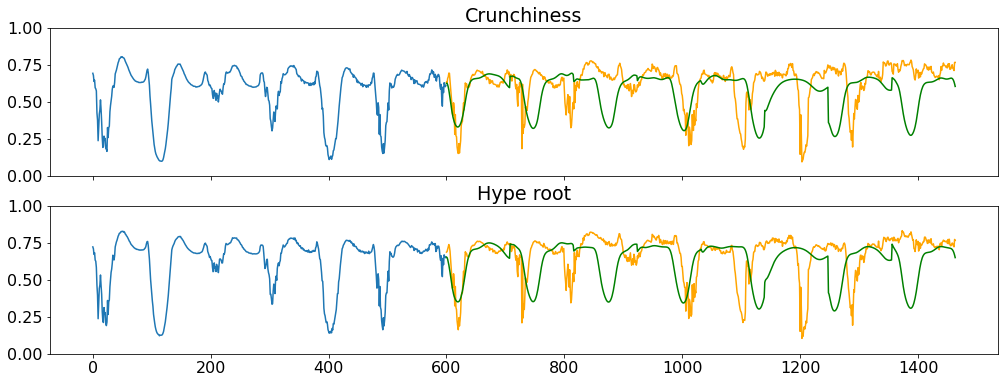

(68400,)
(112, 600, 1)
(1,)


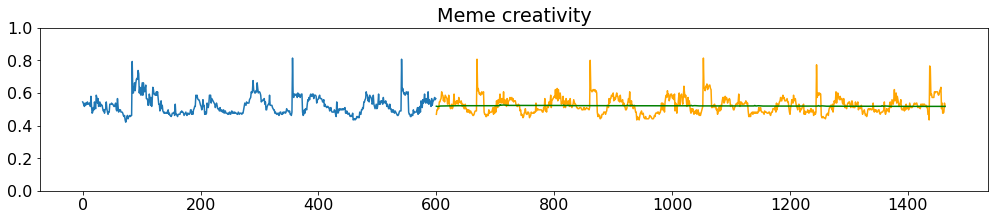

(68400,)
(112, 600, 1)
(1,)


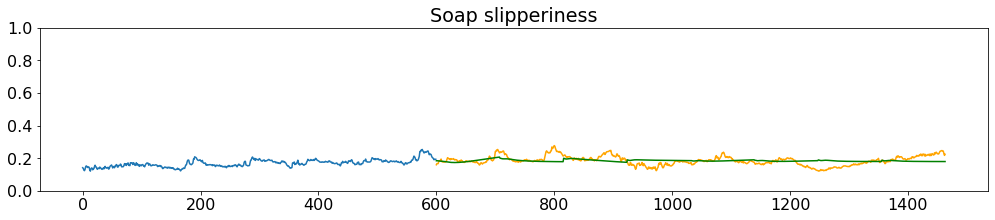

In [38]:
reg_telescope = 864
for i in range(len(models)):
  try:
    data['data'][i][0].name
    X_test_reg, y_test_reg = build_sequences(data['data'][i][0], [data['data'][i][0].name], data['window'][i],  data['window'][i], reg_telescope)
  except AttributeError:
    X_test_reg, y_test_reg = build_sequences(data['data'][i][0], data['data'][i][0].columns, data['window'][i],  data['window'][i], reg_telescope)
  model = models[i]
  
  reg_predictions = np.array([])
  X_temp = X_test_reg
  for reg in range(0,reg_telescope,data['telescope'][i]):
      pred_temp = model.predict(X_temp)
      if(len(reg_predictions)==0):
          reg_predictions = pred_temp
      else:
          reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
      X_temp = np.concatenate((X_temp[:,data['telescope'][i]:,:],pred_temp), axis=1)

  # mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
  # mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
  # print((mean_squared_error, mean_absolute_error))
  try:
    data['data'][i][0].name
    inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, np.array([data['data'][i][0].name]), reg_telescope)
  except AttributeError:
    inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, data['data'][i][0].columns, reg_telescope)
